# Baseline Model
using Random-Forest on sequence data without aggregating, this script only does binary classification between "Underway using engine" and "Engaged in fishing".

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


## Model Choice

A random forest model is chosen as the baseline model due to its efficiency in grasping more complex situation for binary or multi-class classification tasks. The aim is to see if patterns in the data can be processed into meaningful results by a relatively simple model.


## Feature Selection

The features selected are based on their relevance to predicting Navigational Status. These include:
- Speed over Ground (SOG): Vessel speed, which varies significantly across statuses.
- Course over Ground (COG): Direction of the vessel.
- Heading: Indicates the vessel's orientation.

The target variable is Navigational Status.

## Implementation

[Implement your baseline model here.]



Number of sequences: 2229, Sequence length: 120, Features: 5

Accuracy: 0.7892

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       231
           1       0.80      0.75      0.77       215

    accuracy                           0.79       446
   macro avg       0.79      0.79      0.79       446
weighted avg       0.79      0.79      0.79       446



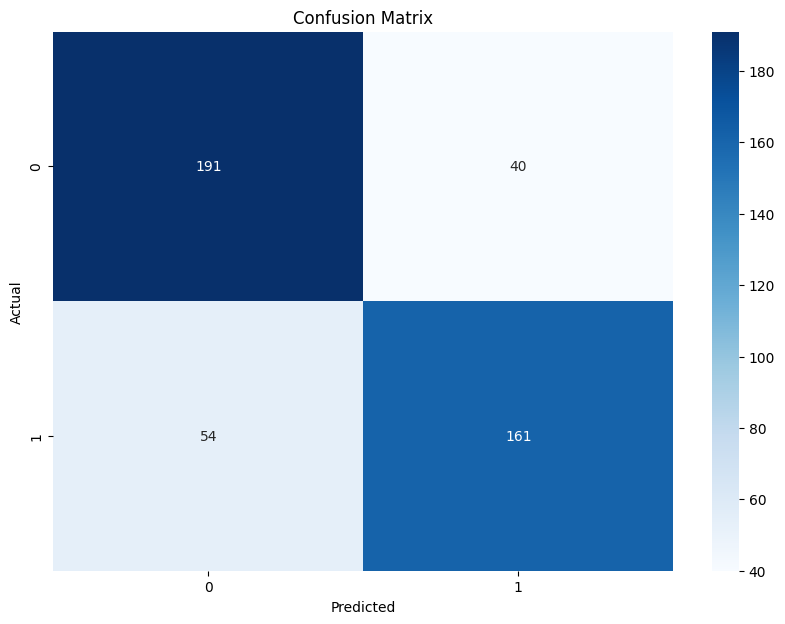

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the folder containing 1-minute step data files
data_folder = '../5_Data_Pipeline/time_sets_st_shortened'

# Parameters for sequence processing
sequence_length = 120  # 1 hour 59 minutes of data (1-minute steps)
feature_columns = ['SOG', 'COG', 'Heading']
target_column = 'Navigational status'

# Function to apply cyclical encoding to COG and Heading
def cyclical_encode(df, column_name):
    # Convert degrees to radians
    radians = np.deg2rad(df[column_name])
    # Compute the sine and cosine components
    df[column_name + '_sin'] = np.sin(radians)
    df[column_name + '_cos'] = np.cos(radians)
    return df

# Initialize lists to store sequences and labels
sequences = []
labels = []

# Process each file
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path)

        # Ensure the required columns exist (excluding the header row)
        if all(col in df.columns for col in feature_columns + [target_column]):
            # Filter to only consider the two relevant "Navigational status" classes
            df = df[df[target_column].isin(['Under way using engine', 'Engaged in fishing'])]

            # If no rows remain after filtering, skip this file
            if df.empty:
                # print(f"Skipping {file}, no valid rows for the selected navigational statuses.")
                continue

            # Apply cyclical encoding for COG and Heading
            df = cyclical_encode(df, 'COG')
            df = cyclical_encode(df, 'Heading')

            # Extract features (use the encoded COG and Heading columns)
            features = df[['SOG', 'COG_sin', 'COG_cos', 'Heading_sin', 'Heading_cos']]
            
            # Get the most common target value (mode) for the file's data
            target = df[target_column].mode()
            if not target.empty:
                target = target[0]  # Use the most common value
            else:
                print(f"Skipping {file}, no valid target values.")
                continue

            # Append the sequence and label
            sequences.append(features.values)
            labels.append(target)
        else:
            print(f"Skipping {file}, missing required columns.")

# Convert lists to NumPy arrays
X = np.array(sequences)  # Shape: [num_samples, sequence_length, num_features]
y = np.array(labels)

# Log dataset information
print(f"Number of sequences: {X.shape[0]}, Sequence length: {X.shape[1]}, Features: {X.shape[2]}")

# Encode target labels
y = pd.Series(y).astype('category').cat.codes.values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten sequences for non-sequence models (e.g., Random Forest)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Evaluation

Evaluation

To evaluate the baseline model:

- Accuracy: Proportion of correct predictions out of all predictions.
- Classification Report: Includes precision, recall, and F1-score for each class, providing detailed insights into model performance.
- Confusion Matrix: Displays actual vs. predicted values to analyze performance for each class.

Example Output:

- Accuracy: Indicates the overall performance.
- Confusion Matrix: Highlights areas where the model misclassified.
- Classification Report: Shows per-class performance metrics, aiding in identifying underperforming categories.

